# Effective Spread

Diego Lozoya Morales | 745345

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'black'

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

In [2]:
data = pd.read_csv('Data/aapl_5m_train.csv').drop(columns=['Unnamed: 0', 'Gmtoffset', 'Volume', 'Timestamp'])
data['diff'] = data['Close'].diff()
data = data.dropna().reset_index(drop=True)
data

,Datetime,Open,High,Low,Close,diff
0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,-0.919998
1,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,0.169998
2,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,0.190003
3,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,-0.660004
4,2021-01-04 14:55:00,132.000000,132.089996,131.300003,131.448898,-0.141098
...,...,...,...,...,...,...
39567,2022-12-30 20:40:00,129.029998,129.130004,128.919998,129.054992,0.014999
39568,2022-12-30 20:45:00,129.059997,129.399993,129.020004,129.380004,0.325012
39569,2022-12-30 20:50:00,129.375000,129.929992,129.330001,129.764404,0.384400
39570,2022-12-30 20:55:00,129.764999,129.949996,129.619995,129.949996,0.185592


$$S = 2\sqrt{|\text{Cov}(\Delta P_t, \Delta P_{t-1})|}$$

## Functions

In [3]:
windows = [5, 10, 20, 50, 100]

def spread_plot(data):
     spread_cols = [c for c in data.columns if "Spread" in c]

     plt.figure()
     for i in range(len(spread_cols)):
          plt.plot(data[spread_cols[i]], color=colors[i], label=spread_cols[i], alpha=0.7)
     plt.title('Spread comparison of AAPL')
     plt.xlabel('Time (5-minute intervals)')
     plt.ylabel('Spread')
     plt.legend()
     plt.show()

def mean_spread_plot(data):
     spread_cols = [c for c in data.columns if "Spread" in c]
     spread_means = [data[col].mean() for col in spread_cols]
     
     plt.figure()
     plt.bar(spread_cols, spread_means, color=colors)
     for i, mean in enumerate(spread_means):
          plt.text(i, mean - 0.015, f'{mean:.4f}', ha='center', va='bottom')
     plt.title('Average Spread per window of AAPL')
     plt.ylabel('Average Spread')
     plt.show()

     return spread_means

def Bid(data, window):
     return np.where(data['diff'] > 0, data['Close'] - data[f'Spread_{window}'], data['Close'])

def Ask(data, window):
     return np.where(data['diff'] < 0, data['Close'] + data[f'Spread_{window}'], data['Close'])

def Bid_Ask_plot(data, window, n):
     for window in windows:
          plt.figure()
          plt.plot(data[f'Bid_{window}'].tail(n), color=colors[0], label=f'Bid_{window}')
          plt.plot(data[f'Ask_{window}'].tail(n), color=colors[1], label=f'Ask_{window}')
          plt.title(f'Last {n} Bid and Ask prices for AAPL with window {window}')
          plt.xlabel('Time (5-minute intervals)')
          plt.ylabel('Price')
          plt.legend()
          plt.show()

## Block Method

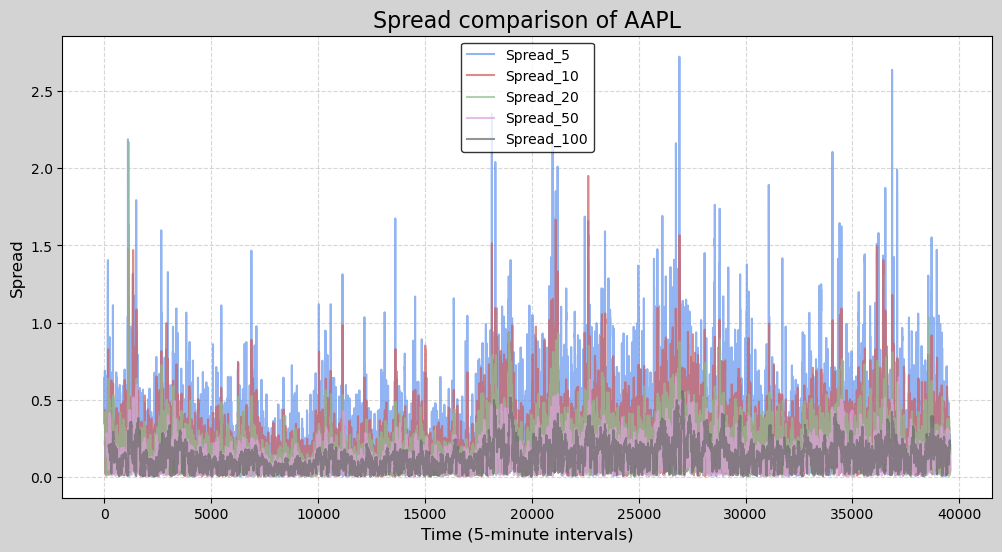

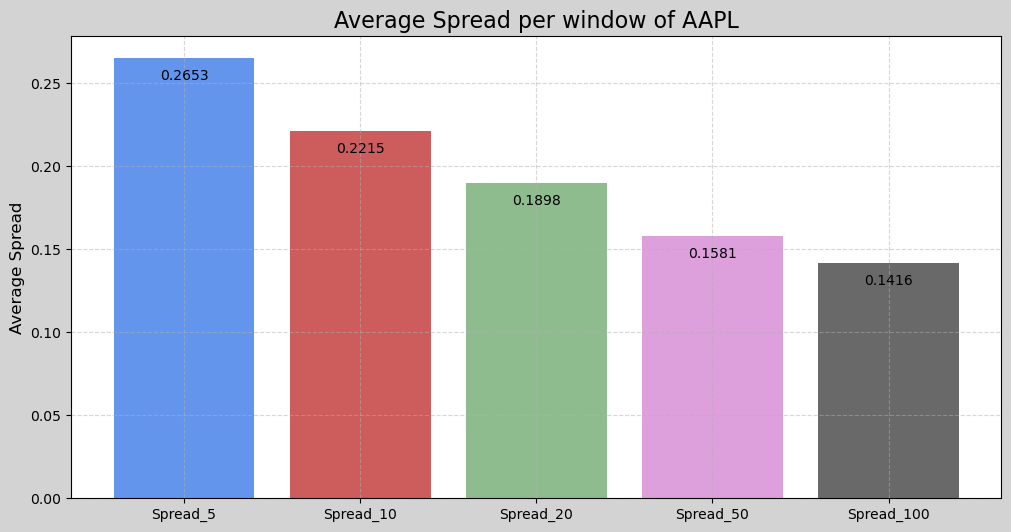

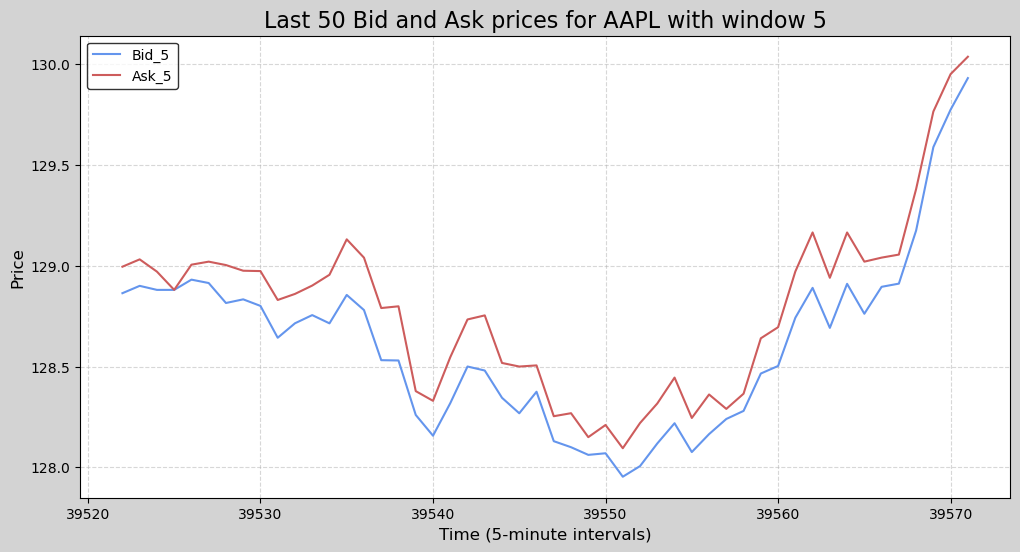

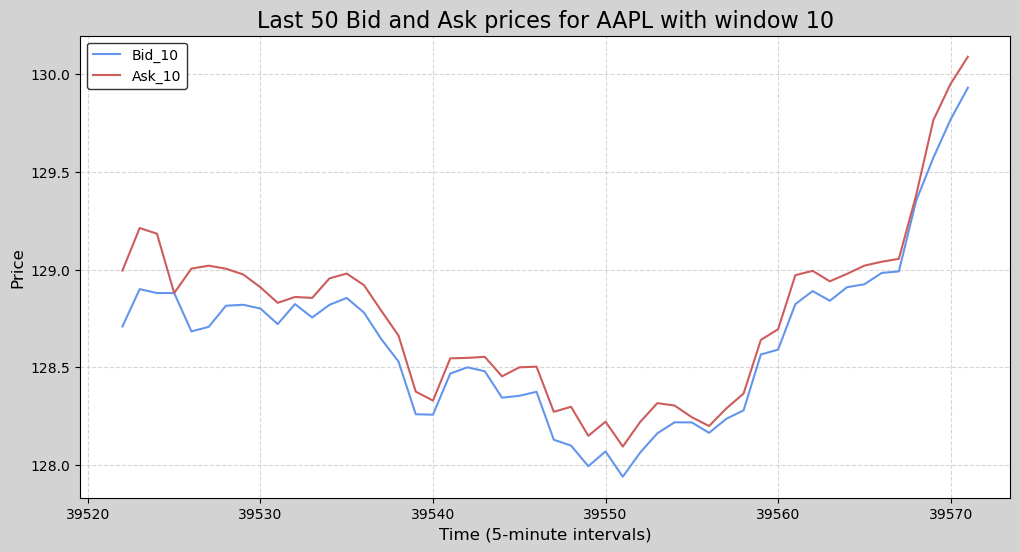

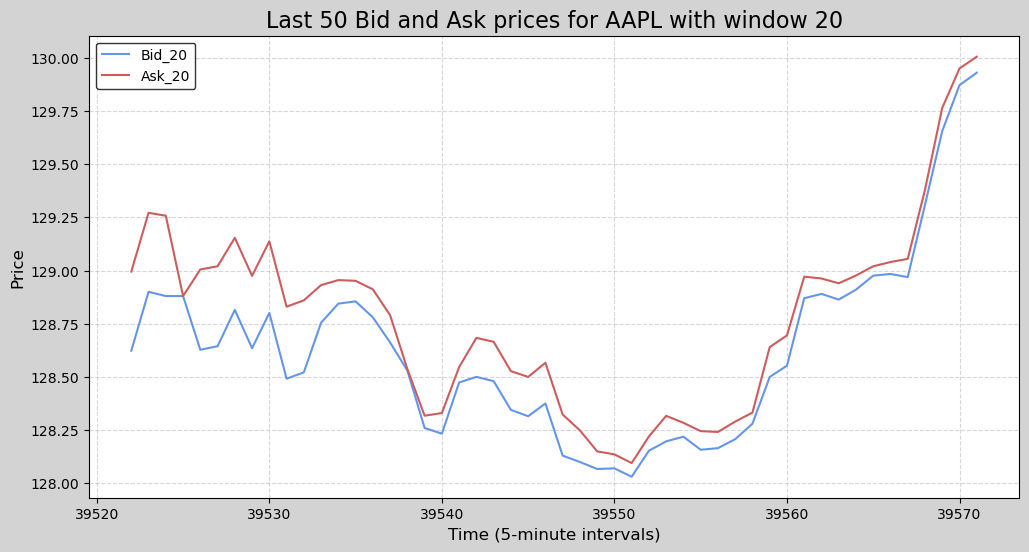

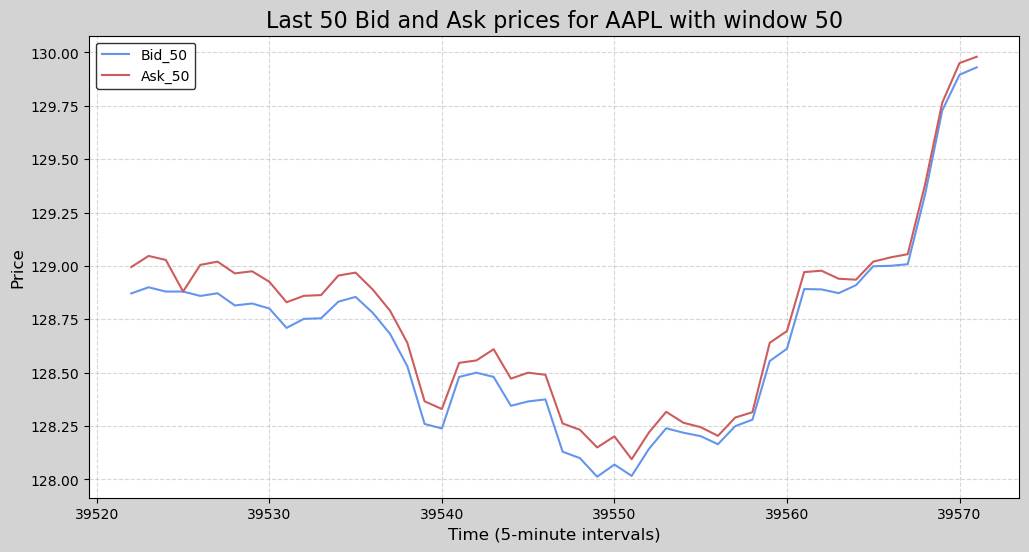

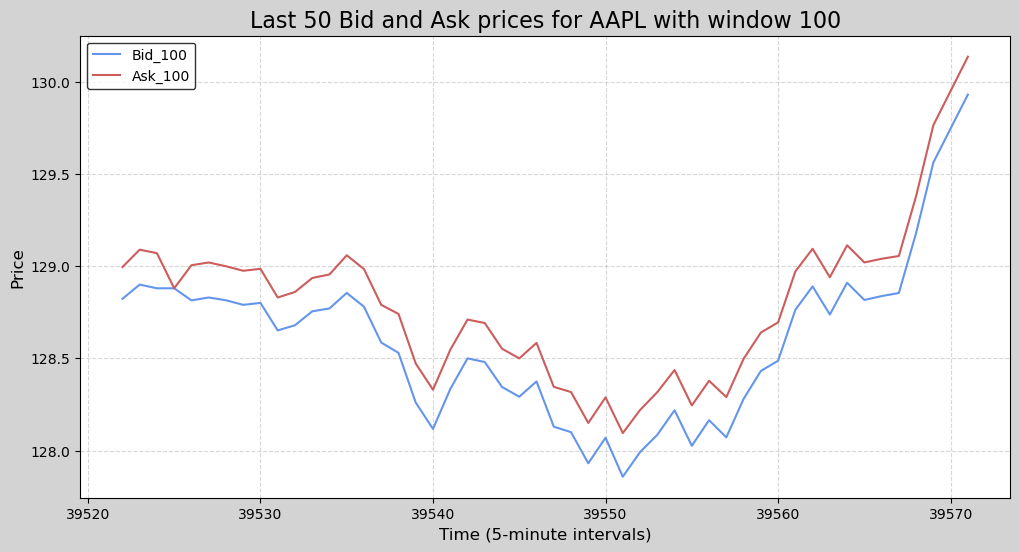

In [4]:
data1 = data.copy()

for window in windows:
     covs = [None] * len(data1)

     for i in range(len(data1) - 2 * window + 1):
          up = data1['diff'][i:i + window]
          down = data1['diff'][i + window:i + 2 * window]

          cov = np.cov(up, down)[0][1]
          covs[i + 2 * window - 1] = cov

     data1[f'Cov_{window}'] = covs
     data1[f'Spread_{window}'] = 2 * np.sqrt(np.abs(data1[f'Cov_{window}']))

spread_plot(data1)
spread_means_bm = mean_spread_plot(data1)

bid_ask = pd.DataFrame()

for window in windows:
     bid_ask[f'Bid_{window}'] = Bid(data1, window) 
     bid_ask[f'Ask_{window}'] = Ask(data1, window)

Bid_Ask_plot(bid_ask, windows, 50)

## Serial Covariance

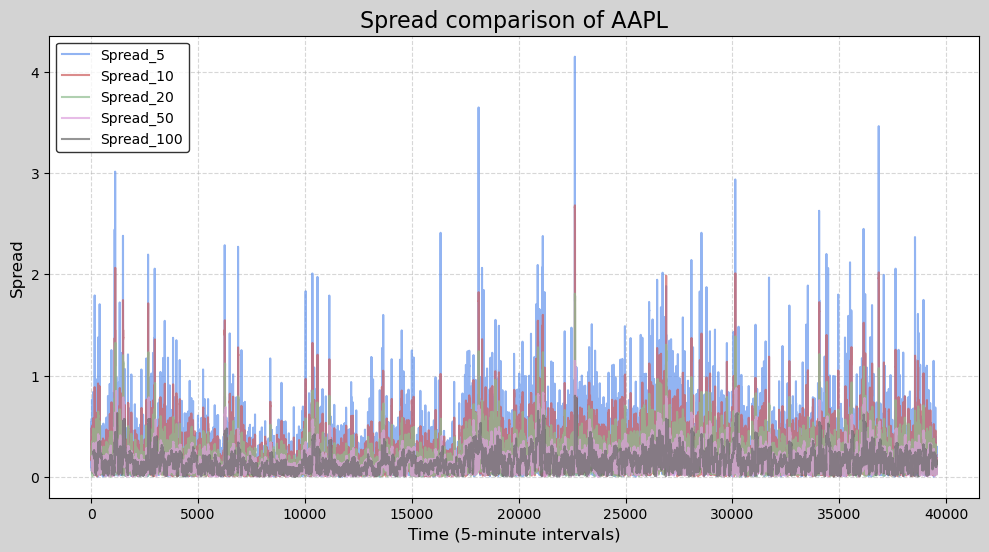

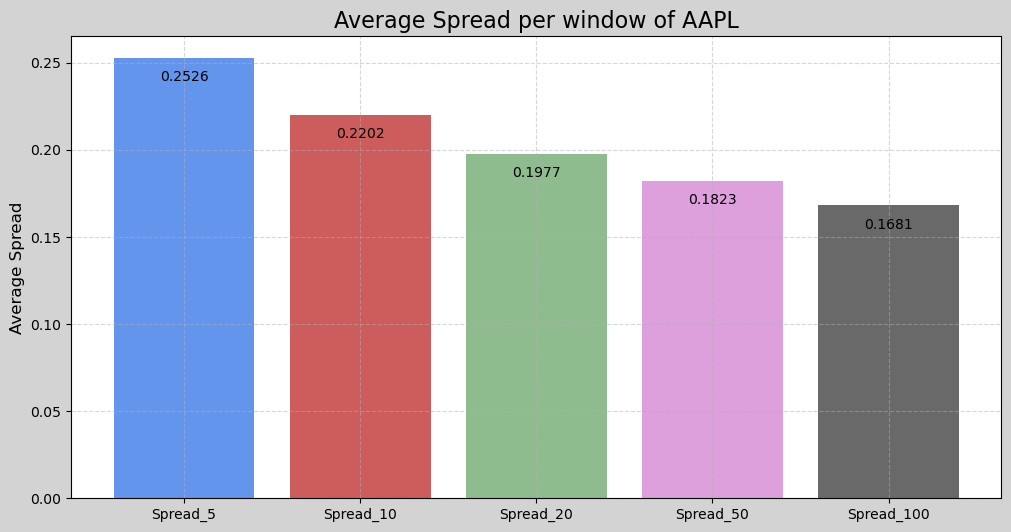

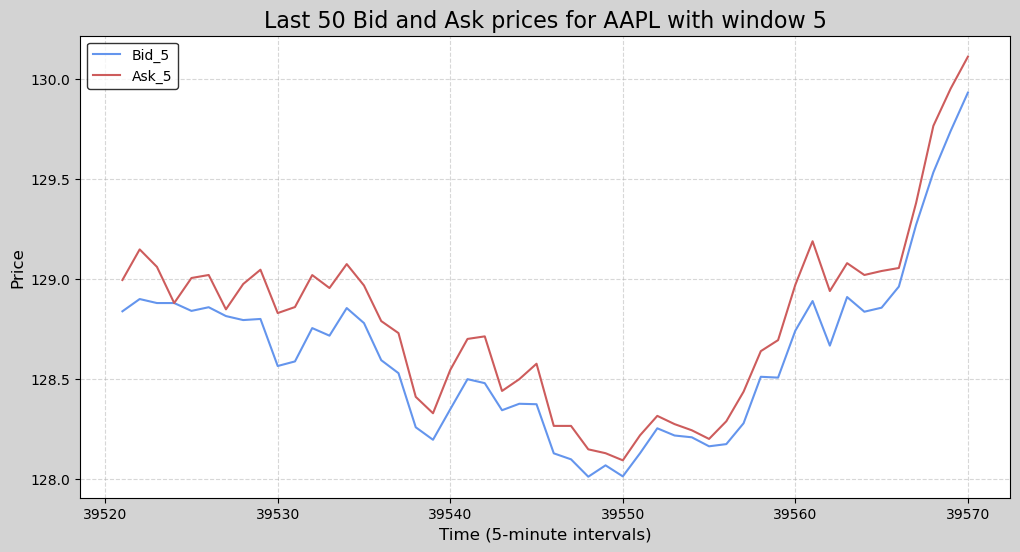

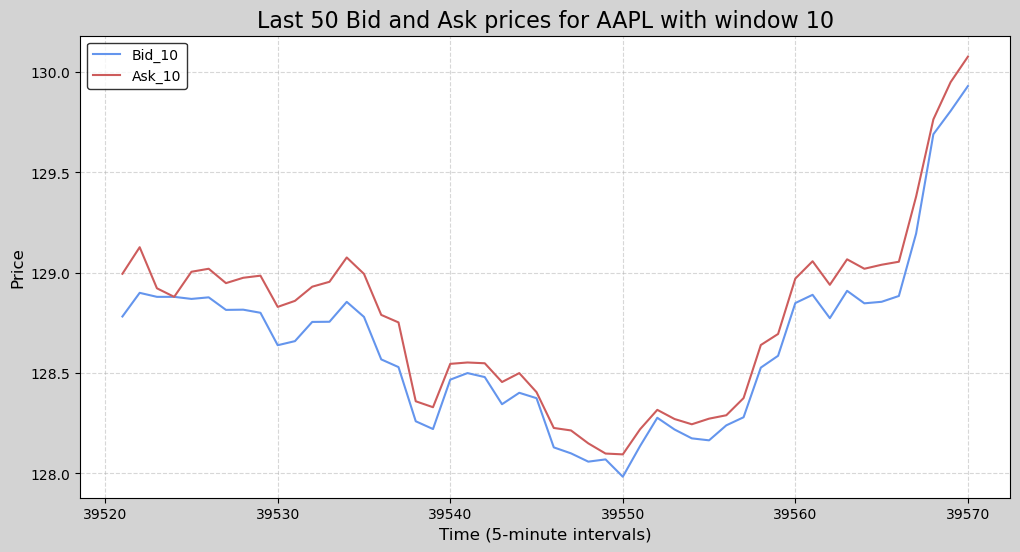

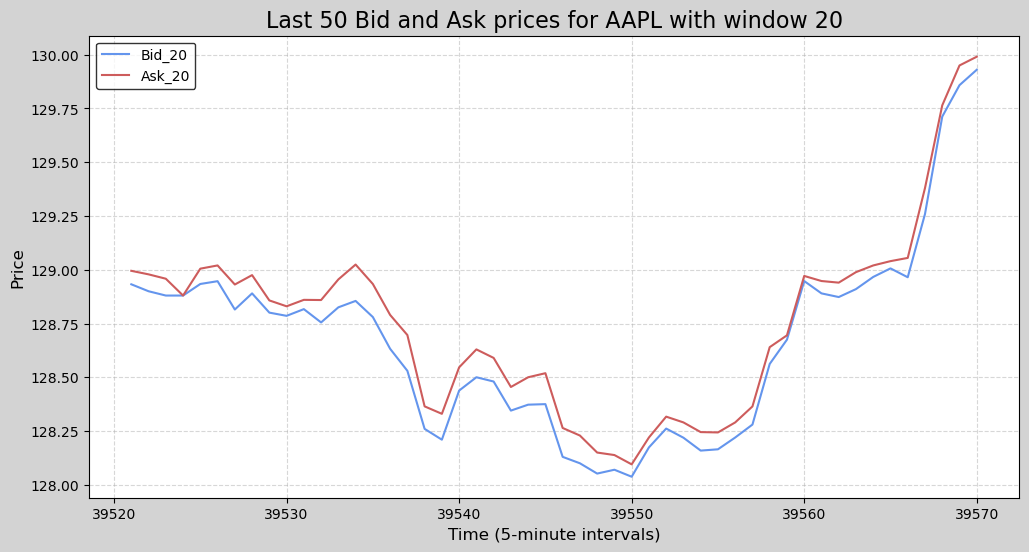

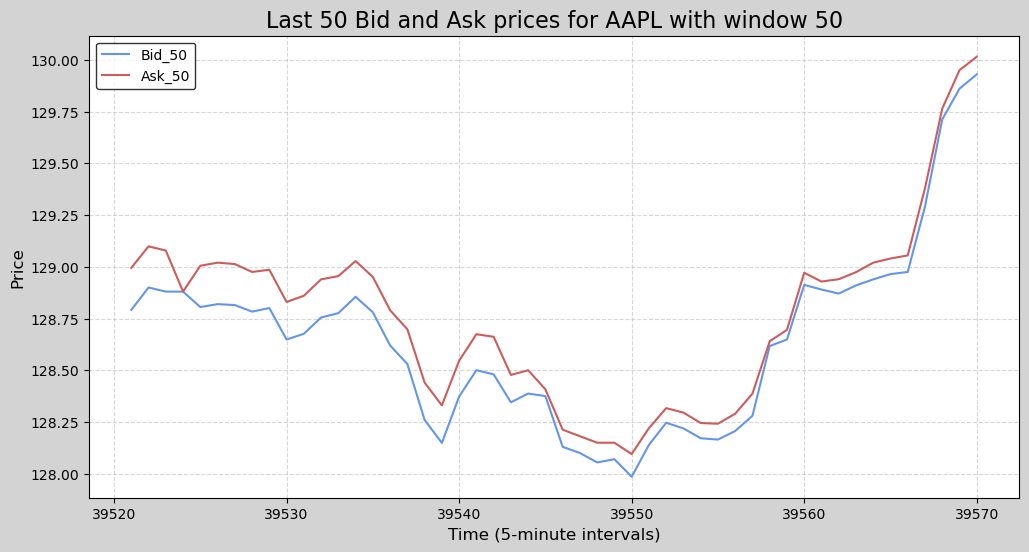

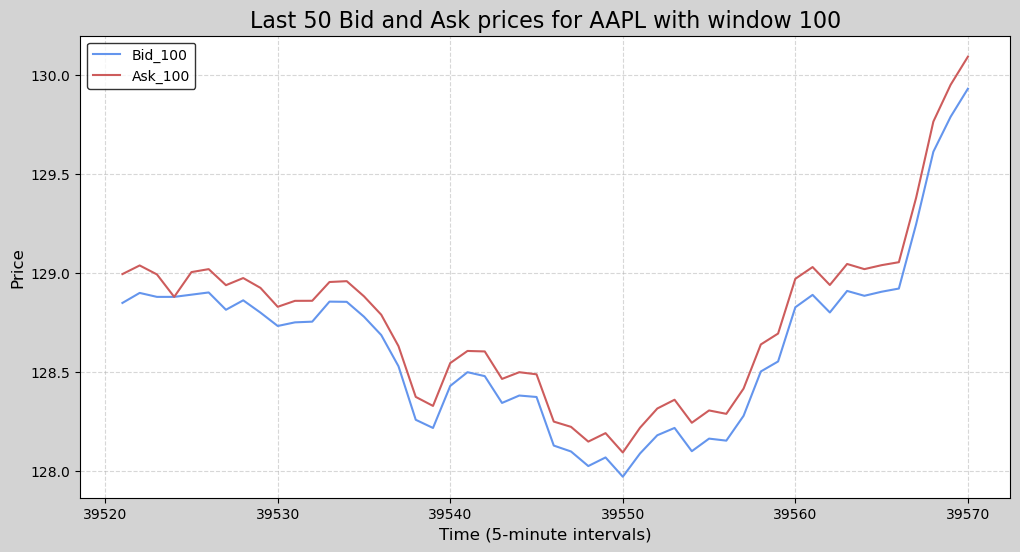

In [5]:
data2 = data.copy()
data2['diff_1'] = data2['diff'].shift(1)
data2 = data2.dropna().reset_index(drop=True)

for window in windows:
     data2[f'Cov_{window}'] = data2['diff'].rolling(window=window).cov(data2['diff_1'])
     data2[f'Spread_{window}'] = 2 * np.sqrt(np.abs(data2[f'Cov_{window}']))

spread_plot(data2)
spread_means_sc = mean_spread_plot(data2)

bid_ask = pd.DataFrame()

for window in windows:
     bid_ask[f'Bid_{window}'] = Bid(data2, window) 
     bid_ask[f'Ask_{window}'] = Ask(data2, window)

Bid_Ask_plot(bid_ask, windows, 50)

## Conclusiones

In [6]:
spread_means_df = pd.DataFrame({
     'BlockMethod': spread_means_bm,
     'SerialCovariance': spread_means_sc
}, index=(['5', '10', '20', '50', '100']))
spread_means_df.index.name = "WindowSize"

spread_means_df

,BlockMethod,SerialCovariance
WindowSize,,
5,0.265275,0.252615
10,0.221454,0.220226
20,0.189835,0.197746
50,0.158118,0.182320
100,0.141632,0.168071


Con base en los resultados de los spreads calculados con ambos metodos a diferentes ventanas temporales se podría concluir que el mejor método de los dos es `Serial Covariance` ya que logra mostrar un mejor ajuste por la correlación entre los retornos, lo que se traduce en una mayor robustez. Al tratarse de un activo tan liquido como los es AAPL, no es necesaria una ventana tan grande para tener una medida estable, por lo que la ventana intermedia de 20, podría ser el balance perfecto entre sensibilidad al micro-ruido y estabilidad del spread calculado.

En resumen el método más adecuado para el cálculo del spread efectivo en esta serie temporal es mediante el método de Serial Covariance y una ventana temporal de 20 observaciones, obteniendo un spread promedio de \$0.1977 USD / acción.